Author: Chris J. Dallmann \
Affiliation: University of Wuerzburg \
Last revision: 21-June-2025

In [19]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import cmocean

In [2]:
# Set parameters 
data_dir = r'E:/Code/Connectomics/Data/'
syn_prediction = 'Princeton' # 'Princeton' for dataset from October 2024
syn_thresh = 5

In [3]:
# Set source neurons
dict_ids = {}
dict_ids['DNg55'] = [720575940622010373]
dict_ids['DNge048'] = [720575940609376707, 720575940617399257]
dict_ids['DNge053'] = [720575940638204132, 720575940630135084]
dict_ids['DNp68'] = [720575940617952034, 720575940615378700]
dict_ids['DNpe053'] = [720575940639242303, 720575940624402173]
dict_ids['DNpe020'] = [720575940624766700]
dict_ids['DNp52'] = [720575940625513360, 720575940616886301]
dict_ids['DNpe042'] = [720575940619038493, 720575940615092019]
dict_ids['DNge150'] = [720575940625489160]
dict_ids['DNge138'] = [720575940627790991]
dict_ids['DNd05'] = [720575940631333195, 720575940629736720]
dict_ids['DNge050'] = [720575940647586948, 720575940611813842]

source_ids = list(itertools.chain(*list(dict_ids.values())))

In [4]:
# Load connectivity 
if syn_prediction == 'Princeton':
    df_connectivity = pd.read_csv(data_dir + 'connectome_connections_flywire_v783_princeton.csv')
    df_connectivity = df_connectivity.rename(columns={"pre_pt_root_id": "pre_root_id", "post_pt_root_id": "post_root_id"}, errors="raise")
else:
    df_connectivity = pd.read_csv(data_dir + 'connectome_connections_flywire_v783.csv')
    
# Load neuron classifications 
df_class = pd.read_csv(data_dir + 'connectome_classifications_flywire_v783.csv')

# Load neurotransmitter information 
df_nt = pd.read_csv(data_dir + 'connectome_neurons_flywire_v783.csv')

In [5]:
# Sum synapses across neuropils
df_connectivity = df_connectivity.groupby(['pre_root_id','post_root_id'])['syn_count'].sum().reset_index().sort_values('syn_count', ascending=False)

In [6]:
# Remove connections between neurons smaller than syn_thresh 
df_connectivity = df_connectivity[df_connectivity.syn_count>=syn_thresh]

In [7]:
# Trim connectivity dataframe
df_connectivity_post = df_connectivity[df_connectivity.pre_root_id.isin(source_ids)]

In [13]:
# Add information about postsynaptic neurons 
super_class = []

for index, row in df_connectivity_post.iterrows():
    super_class.append(df_class.super_class[df_class.root_id==row.post_root_id].item())
    
df_connectivity_post['super_class'] = super_class

In [14]:
df_connectivity_post

,pre_root_id,post_root_id,syn_count,super_class
9568614,720575940624402173,720575940622160705,326,central
18454752,720575940639242303,720575940622160705,297,central
9568740,720575940624402173,720575940623432918,293,central
9567898,720575940624402173,720575940609592270,225,central
9569397,720575940624402173,720575940631299602,213,central
...,...,...,...,...
10361697,720575940625489160,720575940632407826,5,descending
10361811,720575940625489160,720575940645056791,5,central
10379273,720575940625513360,720575940645538158,5,central
10379221,720575940625513360,720575940631299602,5,central


## Compute connectivity with super classes

In [68]:
# Initialize synapse dictionary
super_classes = df_connectivity_post.super_class.unique().tolist() 
dict_synapses = {}
for source_id in source_ids:
    dict_synapses[source_id] = {}
    for super_class in super_classes:
        dict_synapses[source_id][super_class] = 0

In [69]:
# Populate synapse dictionary
for source_id in source_ids:
    syn_count_total = df_connectivity.syn_count[df_connectivity.pre_root_id == source_id].sum().item()
    # Use original df_connectivity to get total synapse count

    for super_class in super_classes:
        syn_count = df_connectivity_post.syn_count[(df_connectivity_post.pre_root_id == source_id) & (df_connectivity_post.super_class == super_class)].sum().item()
        dict_synapses[source_id][super_class] += syn_count / syn_count_total

In [70]:
# Build connectivity matrix
connectivity_matrix = np.zeros((len(source_ids),len(super_classes)))
for source_index, source_id in enumerate(dict_synapses.keys()):
    for super_class_index, super_class in enumerate(super_classes):
        connectivity_matrix[source_index,super_class_index] = dict_synapses[source_id][super_class]

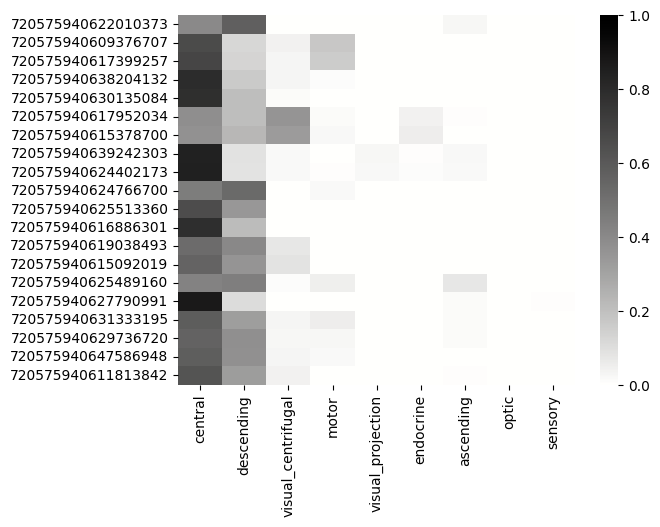

In [71]:
# Plot connectivity matrix
neuron_names = list(dict_ids.keys())

cmap = cmocean.cm.gray_r

sns.heatmap(connectivity_matrix,
            yticklabels = source_ids,
            xticklabels = super_classes,
            cmap = cmap,
            vmax = 1)
#plt.savefig(r"C:\Users\Chris\Desktop\connectivity_matrix.eps", bbox_inches="tight", transparent=True)
plt.show()

In [72]:
# Average rows for the same source neuron type
neuron_names = list(dict_ids.keys())
connectivity_matrix_grouped = np.zeros((len(neuron_names),np.size(connectivity_matrix,axis=1)))
for key_index, key in enumerate(neuron_names):
    n_neurons = len(dict_ids[key])   
    if key_index == 0:
        start_index = 0
    else:
        start_index = end_index 
    end_index = start_index + n_neurons
    
    connectivity_matrix_grouped[key_index,:] = np.mean(connectivity_matrix[start_index:end_index,],axis=0)

connectivity_matrix = connectivity_matrix_grouped
del connectivity_matrix_grouped

In [73]:
# Sort connectivity matrix 
neuron_names = list(dict_ids.keys())

# Sort rows based on ... ipynb
sort_index = [5, 10, 1, 11, 4, 3, 8, 6, 7, 0, 2, 9]
connectivity_matrix = connectivity_matrix[[i for i in sort_index],:]
neuron_names = [neuron_names[i] for i in sort_index]

# Sort columns
sort_list = ['central','descending','ascending','motor','sensory','visual_centrifugal','visual_projection','optic','endocrine']
sort_index = [super_classes.index(i) for i in sort_list]
connectivity_matrix = connectivity_matrix[:, [i for i in sort_index]]
super_classes = [super_classes[i] for i in sort_index]

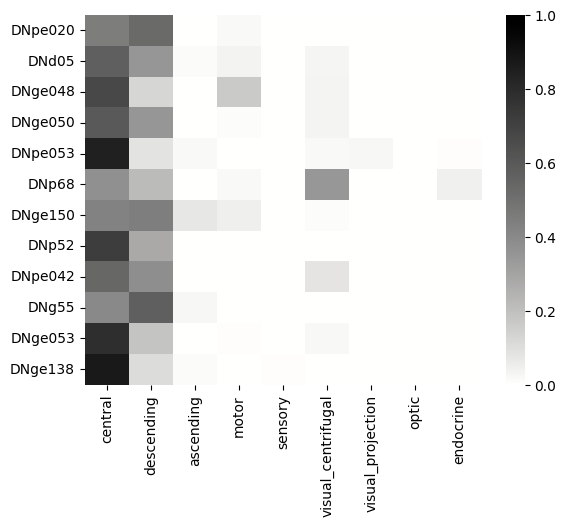

In [74]:
# Plot connectivity matrix
cmap = cmocean.cm.gray_r

sns.heatmap(connectivity_matrix,
            yticklabels = neuron_names,
            xticklabels = super_classes,
            cmap = cmap,
            vmax = 1)
#plt.savefig(r"C:\Users\Chris\Desktop\connectivity_matrix.eps", bbox_inches="tight", transparent=True)
plt.show()

In [45]:
#connectivity_matrix.sum(axis=1)

## Compute connectivity onto each other

In [64]:
# Build connectivity matrix
connectivity_matrix = np.zeros((len(source_ids),len(source_ids)))
for row_index, row_id in enumerate(dict_synapses.keys()):
    for col_index, col_id in enumerate(dict_synapses.keys()):
        syn_count = df_connectivity_post.syn_count[(df_connectivity_post.pre_root_id == row_id) & (df_connectivity_post.post_root_id == col_id)].sum().item()
        connectivity_matrix[row_index,col_index] += syn_count

In [65]:
# Average rows for the same source neuron type
neuron_names = list(dict_ids.keys())
connectivity_matrix_grouped = np.zeros((len(neuron_names),len(source_ids)))
for key_index, key in enumerate(neuron_names):
    n_neurons = len(dict_ids[key])   
    if key_index == 0:
        start_index = 0
    else:
        start_index = end_index 
    end_index = start_index + n_neurons
    
    connectivity_matrix_grouped[key_index,:] = np.mean(connectivity_matrix[start_index:end_index,],axis=0)

connectivity_matrix = connectivity_matrix_grouped
del connectivity_matrix_grouped

# Average columns for the same source neuron type
neuron_names = list(dict_ids.keys())
connectivity_matrix_grouped = np.zeros((len(neuron_names),len(neuron_names)))
for key_index, key in enumerate(neuron_names):
    n_neurons = len(dict_ids[key])   
    if key_index == 0:
        start_index = 0
    else:
        start_index = end_index 
    end_index = start_index + n_neurons
    
    connectivity_matrix_grouped[:,key_index] = np.mean(connectivity_matrix[:,start_index:end_index],axis=1)

connectivity_matrix = connectivity_matrix_grouped
del connectivity_matrix_grouped

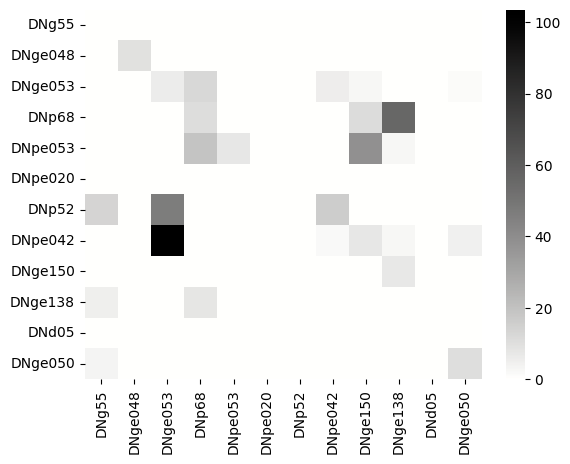

In [66]:
# Plot connectivity matrix
cmap = cmocean.cm.gray_r

sns.heatmap(connectivity_matrix,
            yticklabels = neuron_names,
            xticklabels = neuron_names,
            cmap = cmap
           )
#plt.savefig(r"C:\Users\Chris\Desktop\connectivity_matrix.eps", bbox_inches="tight", transparent=True)
plt.show()